# 新闻场景截图的分类

## 导入全局代码

In [1]:
from IPython.display import display

import time
import os
import copy
import sys
import random
import math
from glob import glob
from datetime import timedelta

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import skimage.io
import matplotlib.pyplot as plt
import pandas as pd
import holoviews as hv
import hvplot.pandas

from tqdm import tqdm


## 常量定义

### 普通常量

In [2]:
import sys

DATA_DIR = '../data/images/dev'
BATCH_SIZE = 4
NUM_EPOCHS = 60
LEARNING_RATE = 1e-5
INPUT_SIZE = 224
DATA_PARALLEL = False

phases = ['train', 'val']

# Flag for feature extracting.
#   - When False, we finetune the whole model,
#   - when True we only update the reshaped layer params
feature_extract = True

# 模型种类，输出路径
model_export_dir = 'out'
model_name = "squeezenet1_0"
model_export_file = os.path.join(model_export_dir, '{0}-{1}-py{2[0]}{2[1]}.pkl'.format(model_name, INPUT_SIZE, sys.version_info))

### 图形变形器

`torchvision` 预训练模型的的数据相当的“硬核”，其转换方式如下:

> **ℹ Tips:**
>
> 使用 [`torchvision.datasets.ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) 这个类

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]),
}

## 加载训练数据集

### ImageFolder 加载和分割

In [4]:
def decompose_int_by_rates(i, percents):
    if not isinstance(i, int):
        raise TypeError(f'Expected type of argument `i` is `int`, but `{type(i)}` actually')
    if i < 0:
        raise ValueError('Argument `i` can not be smaller than zero')
    if sum(percents) >= 1.0:
        raise ValueError('Sum of percents can not be greater than or equal to `1.0`')
    result = []
    for percent in percents:
        result.append(math.trunc(i * percent))
    result.append(i - sum(result))
    return result

print("初始化：数据集 数据加载器 ...")

# Create training and validation datasets
images_dataset = datasets.ImageFolder(DATA_DIR)
lengths = decompose_int_by_rates(len(images_dataset), [.9,])
datasets_dict = {
    phase: subset
    for phase, subset in zip(phases, random_split(images_dataset, lengths))
}
for phase, sebset in datasets_dict.items():
    sebset.dataset.transform = data_transforms[phase]

display(pd.DataFrame(
    {'name': x, 'size': len(subset)}
    for x, subset in datasets_dict.items()
))

# Create training and validation dataloaders
dataloaders_dict = {
    x: DataLoader(
        datasets_dict[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )
    for x in phases
}

classes = images_dataset.classes
num_classes = len(classes)

display(pd.DataFrame({
    '图片分类': classes
}))

初始化：数据集 数据加载器 ...


name  size
0  train  2577
1    val   287

图片分类
0  无字幕内容
1  有字幕内容
2    演播室

### torchvision 张量转 matplotlib 数组

In [5]:
def torchim_show(image_tensor, show=True, pause=0.001):
    pause = float(pause)
    image_tensor_denormalized = (image_tensor + 1) / 2
    image_array = image_tensor_denormalized.numpy().transpose(1, 2, 0)
    if show:
        plt.imshow(image_array)
        if pause > 0:
            plt.pause(pause)
    return image_array

### 显示一批训练数据

有字幕内容


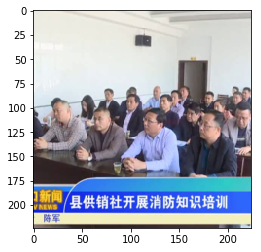

无字幕内容


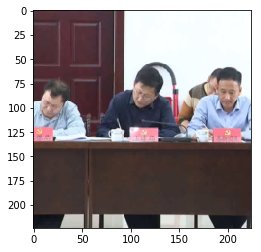

无字幕内容


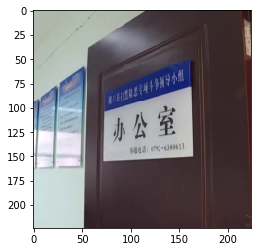

无字幕内容


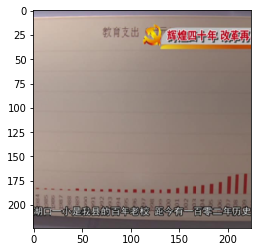

In [6]:
for inputs, labels in dataloaders_dict['train']:
    batch_size = inputs.size(0)
    for i in range(batch_size):
        label = labels[i].item()
        img = inputs[i]
        print(classes[label])
        torchim_show(img)
    break

## GPU / CPU 设备

就像将Tensor转到GPU一样，可将神经网络转到GPU。

如果有可用的CUDA，我们首先获取第一个可见的cuda设备：

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda


## 帮助函数定义

### 模型的训练/验证函数

In [8]:
def train_model(model, device, dataloaders, criterion, optimizer, epochs, is_inception=False, predict_value_threshold=None):
    since = time.time()

    history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = -1
    
    for epoch in range(epochs):
        epoch_desc = f'Epoch {epoch+1}/{epochs}'
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            
            # detect batch size
            for inputs, labels in dataloaders[phase]:
                batch_size = inputs.size(0)
                break

            # Iterate over data.
            for i, (inputs, labels) in tqdm(
                enumerate(dataloaders[phase]),
                desc=f'{epoch_desc} - {phase}',
                total=math.ceil(len(dataloaders[phase].dataset) / batch_size),
                unit='batch(s)'
            ):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    pred_values, pred_indeces = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += sum(
                    pred_index == label
                    for pred_value, pred_index, label
                    in zip(*(m.tolist() for m in (pred_values, pred_indeces, labels)))
                    if (predict_value_threshold is None) or (pred_value >= predict_value_threshold)
                )
               
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            history.append({
                'epoch': epoch,
                'phase': phase,
                'acc': epoch_acc,
                'loss': epoch_loss,
            })

            # deep copy the model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    best_model_wts = copy.deepcopy(model.state_dict())
                best_acc_check_symbol = f"{'✔' if best_epoch == epoch else '✖'}"
                print(
                    f'{epoch_desc} - {phase}  Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}  best({best_acc_check_symbol})'
                )
            else:
                print(
                    f'{epoch_desc} - {phase}  Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}'
                )
        print()

    print(f'Training complete in {timedelta(seconds=time.time() - since)}')
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


### 设置模型参数的 `.requires_grad` 属性

设置为 `False` 表示正在进行 **feature extracting**。

一般来说，预训练模型的所有参数均是 `.requires_grad=True`。

但是我们在  **feature extracting** 时，只需要对新初始化的层进行梯度计算，所以要让这些参数与要计算的梯度无关。

In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## 神经网络的初始化和改造

### 定义模型的初始化函数

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = INPUT_SIZE

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = INPUT_SIZE

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = INPUT_SIZE

    elif model_name == "squeezenet1_0":
        """ Squeezenet 1.0
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = INPUT_SIZE


    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

### 执行模型的初始化函数

In [11]:
is_inception = model_name=="inception"

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

if device != 'cpu':
    # parallel model
    if DATA_PARALLEL:
        model_ft = nn.DataParallel(model_ft)
    # Send the model to GPU if have one
    model_ft = model_ft.to(device)

print('Model: ', model_ft)

/home/liuxy/miniconda3/envs/jxcn-newsvideo/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/liuxy/miniconda3/envs/jxcn-newsvideo/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


Model:  SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 3

## 优化器

In [12]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=LEARNING_RATE, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


## 损失函数

In [13]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

## 执行训练和验证步骤

### 执行训练过程

In [14]:
# Train and evaluate
model_ft, hist = train_model(model_ft, device, dataloaders_dict, criterion, optimizer_ft, NUM_EPOCHS, is_inception, predict_value_threshold=6.0)

Epoch 1/60 - train: 100%|██████████| 645/645 [00:12<00:00, 50.87batch(s)/s]

Epoch 1/60 - train  Loss: 0.7110 Acc: 0.0182



Epoch 1/60 - val: 100%|██████████| 72/72 [00:01<00:00, 53.06batch(s)/s]

Epoch 1/60 - val  Loss: 0.4460 Acc: 0.0279  best(✔)




Epoch 2/60 - train: 100%|██████████| 645/645 [00:11<00:00, 55.01batch(s)/s]

Epoch 2/60 - train  Loss: 0.3644 Acc: 0.1257



Epoch 2/60 - val: 100%|██████████| 72/72 [00:01<00:00, 49.12batch(s)/s]

Epoch 2/60 - val  Loss: 0.3037 Acc: 0.0976  best(✔)




Epoch 3/60 - train: 100%|██████████| 645/645 [00:10<00:00, 60.68batch(s)/s]

Epoch 3/60 - train  Loss: 0.2823 Acc: 0.3198



Epoch 3/60 - val: 100%|██████████| 72/72 [00:01<00:00, 65.49batch(s)/s]

Epoch 3/60 - val  Loss: 0.2484 Acc: 0.1986  best(✔)




Epoch 4/60 - train: 100%|██████████| 645/645 [00:10<00:00, 60.03batch(s)/s]

Epoch 4/60 - train  Loss: 0.2429 Acc: 0.4501



Epoch 4/60 - val: 100%|██████████| 72/72 [00:01<00:00, 50.75batch(s)/s]

Epoch 4/60 - val  Loss: 0.2202 Acc: 0.3136  best(✔)




Epoch 5/60 - train: 100%|██████████| 645/645 [00:12<00:00, 53.08batch(s)/s]

Epoch 5/60 - train  Loss: 0.2232 Acc: 0.5452



Epoch 5/60 - val: 100%|██████████| 72/72 [00:01<00:00, 44.24batch(s)/s]

Epoch 5/60 - val  Loss: 0.2035 Acc: 0.4181  best(✔)




Epoch 6/60 - train: 100%|██████████| 645/645 [00:11<00:00, 56.66batch(s)/s]

Epoch 6/60 - train  Loss: 0.2088 Acc: 0.6034



Epoch 6/60 - val: 100%|██████████| 72/72 [00:01<00:00, 58.64batch(s)/s]

Epoch 6/60 - val  Loss: 0.1902 Acc: 0.4739  best(✔)




Epoch 7/60 - train: 100%|██████████| 645/645 [00:11<00:00, 55.69batch(s)/s]

Epoch 7/60 - train  Loss: 0.1999 Acc: 0.6395



Epoch 7/60 - val: 100%|██████████| 72/72 [00:01<00:00, 45.47batch(s)/s]

Epoch 7/60 - val  Loss: 0.1788 Acc: 0.5505  best(✔)




Epoch 8/60 - train: 100%|██████████| 645/645 [00:10<00:00, 59.68batch(s)/s]

Epoch 8/60 - train  Loss: 0.1873 Acc: 0.6993



Epoch 8/60 - val: 100%|██████████| 72/72 [00:01<00:00, 43.75batch(s)/s]

Epoch 8/60 - val  Loss: 0.1694 Acc: 0.6028  best(✔)




Epoch 9/60 - train: 100%|██████████| 645/645 [00:11<00:00, 58.33batch(s)/s]

Epoch 9/60 - train  Loss: 0.1760 Acc: 0.7330



Epoch 9/60 - val: 100%|██████████| 72/72 [00:01<00:00, 58.90batch(s)/s]

Epoch 9/60 - val  Loss: 0.1612 Acc: 0.6620  best(✔)




Epoch 10/60 - train: 100%|██████████| 645/645 [00:09<00:00, 67.37batch(s)/s]


Epoch 10/60 - train  Loss: 0.1740 Acc: 0.7699


Epoch 10/60 - val: 100%|██████████| 72/72 [00:01<00:00, 58.04batch(s)/s]

Epoch 10/60 - val  Loss: 0.1568 Acc: 0.6690  best(✔)




Epoch 11/60 - train: 100%|██████████| 645/645 [00:11<00:00, 57.91batch(s)/s]

Epoch 11/60 - train  Loss: 0.1634 Acc: 0.7982



Epoch 11/60 - val: 100%|██████████| 72/72 [00:01<00:00, 48.64batch(s)/s]

Epoch 11/60 - val  Loss: 0.1478 Acc: 0.7282  best(✔)




Epoch 12/60 - train: 100%|██████████| 645/645 [00:11<00:00, 55.69batch(s)/s]

Epoch 12/60 - train  Loss: 0.1594 Acc: 0.8324



Epoch 12/60 - val: 100%|██████████| 72/72 [00:01<00:00, 54.10batch(s)/s]

Epoch 12/60 - val  Loss: 0.1423 Acc: 0.7631  best(✔)




Epoch 13/60 - train: 100%|██████████| 645/645 [00:11<00:00, 56.81batch(s)/s]

Epoch 13/60 - train  Loss: 0.1519 Acc: 0.8417



Epoch 13/60 - val: 100%|██████████| 72/72 [00:01<00:00, 57.99batch(s)/s]

Epoch 13/60 - val  Loss: 0.1371 Acc: 0.7805  best(✔)




Epoch 14/60 - train: 100%|██████████| 645/645 [00:11<00:00, 57.21batch(s)/s]

Epoch 14/60 - train  Loss: 0.1480 Acc: 0.8650



Epoch 14/60 - val: 100%|██████████| 72/72 [00:01<00:00, 50.60batch(s)/s]

Epoch 14/60 - val  Loss: 0.1308 Acc: 0.8258  best(✔)




Epoch 15/60 - train: 100%|██████████| 645/645 [00:11<00:00, 56.20batch(s)/s]

Epoch 15/60 - train  Loss: 0.1452 Acc: 0.8820



Epoch 15/60 - val: 100%|██████████| 72/72 [00:01<00:00, 56.98batch(s)/s]

Epoch 15/60 - val  Loss: 0.1266 Acc: 0.8397  best(✔)




Epoch 16/60 - train: 100%|██████████| 645/645 [00:10<00:00, 60.99batch(s)/s]

Epoch 16/60 - train  Loss: 0.1393 Acc: 0.8948



Epoch 16/60 - val: 100%|██████████| 72/72 [00:01<00:00, 53.23batch(s)/s]

Epoch 16/60 - val  Loss: 0.1232 Acc: 0.8676  best(✔)




Epoch 17/60 - train: 100%|██████████| 645/645 [00:11<00:00, 62.25batch(s)/s]

Epoch 17/60 - train  Loss: 0.1329 Acc: 0.9042



Epoch 17/60 - val: 100%|██████████| 72/72 [00:01<00:00, 49.60batch(s)/s]

Epoch 17/60 - val  Loss: 0.1194 Acc: 0.8780  best(✔)




Epoch 18/60 - train: 100%|██████████| 645/645 [00:12<00:00, 53.69batch(s)/s]

Epoch 18/60 - train  Loss: 0.1279 Acc: 0.9127



Epoch 18/60 - val: 100%|██████████| 72/72 [00:01<00:00, 52.42batch(s)/s]

Epoch 18/60 - val  Loss: 0.1162 Acc: 0.8955  best(✔)




Epoch 19/60 - train: 100%|██████████| 645/645 [00:11<00:00, 54.95batch(s)/s]

Epoch 19/60 - train  Loss: 0.1204 Acc: 0.9146



Epoch 19/60 - val: 100%|██████████| 72/72 [00:01<00:00, 43.06batch(s)/s]

Epoch 19/60 - val  Loss: 0.1114 Acc: 0.9164  best(✔)




Epoch 20/60 - train: 100%|██████████| 645/645 [00:11<00:00, 57.23batch(s)/s]

Epoch 20/60 - train  Loss: 0.1215 Acc: 0.9305



Epoch 20/60 - val: 100%|██████████| 72/72 [00:01<00:00, 53.79batch(s)/s]


Epoch 20/60 - val  Loss: 0.1090 Acc: 0.9268  best(✔)



Epoch 21/60 - train: 100%|██████████| 645/645 [00:11<00:00, 58.44batch(s)/s]

Epoch 21/60 - train  Loss: 0.1172 Acc: 0.9352



Epoch 21/60 - val: 100%|██████████| 72/72 [00:01<00:00, 46.57batch(s)/s]

Epoch 21/60 - val  Loss: 0.1060 Acc: 0.9373  best(✔)




Epoch 22/60 - train: 100%|██████████| 645/645 [00:11<00:00, 54.67batch(s)/s]

Epoch 22/60 - train  Loss: 0.1141 Acc: 0.9375



Epoch 22/60 - val: 100%|██████████| 72/72 [00:01<00:00, 45.14batch(s)/s]

Epoch 22/60 - val  Loss: 0.1043 Acc: 0.9373  best(✖)




Epoch 23/60 - train: 100%|██████████| 645/645 [00:11<00:00, 56.62batch(s)/s]

Epoch 23/60 - train  Loss: 0.1141 Acc: 0.9472



Epoch 23/60 - val: 100%|██████████| 72/72 [00:01<00:00, 48.85batch(s)/s]

Epoch 23/60 - val  Loss: 0.1006 Acc: 0.9512  best(✔)




Epoch 24/60 - train: 100%|██████████| 645/645 [00:11<00:00, 56.77batch(s)/s]

Epoch 24/60 - train  Loss: 0.1112 Acc: 0.9515



Epoch 24/60 - val: 100%|██████████| 72/72 [00:01<00:00, 50.23batch(s)/s]

Epoch 24/60 - val  Loss: 0.0976 Acc: 0.9652  best(✔)




Epoch 25/60 - train: 100%|██████████| 645/645 [00:10<00:00, 58.80batch(s)/s]

Epoch 25/60 - train  Loss: 0.1082 Acc: 0.9507



Epoch 25/60 - val: 100%|██████████| 72/72 [00:01<00:00, 63.38batch(s)/s]

Epoch 25/60 - val  Loss: 0.0965 Acc: 0.9547  best(✖)




Epoch 26/60 - train: 100%|██████████| 645/645 [00:10<00:00, 59.90batch(s)/s]

Epoch 26/60 - train  Loss: 0.1103 Acc: 0.9530



Epoch 26/60 - val: 100%|██████████| 72/72 [00:01<00:00, 48.02batch(s)/s]

Epoch 26/60 - val  Loss: 0.0938 Acc: 0.9617  best(✖)




Epoch 27/60 - train: 100%|██████████| 645/645 [00:11<00:00, 55.24batch(s)/s]

Epoch 27/60 - train  Loss: 0.1073 Acc: 0.9542



Epoch 27/60 - val: 100%|██████████| 72/72 [00:01<00:00, 51.61batch(s)/s]

Epoch 27/60 - val  Loss: 0.0925 Acc: 0.9582  best(✖)




Epoch 28/60 - train: 100%|██████████| 645/645 [00:11<00:00, 54.18batch(s)/s]

Epoch 28/60 - train  Loss: 0.1052 Acc: 0.9604



Epoch 28/60 - val: 100%|██████████| 72/72 [00:01<00:00, 53.76batch(s)/s]

Epoch 28/60 - val  Loss: 0.0905 Acc: 0.9582  best(✖)




Epoch 29/60 - train: 100%|██████████| 645/645 [00:11<00:00, 56.04batch(s)/s]

Epoch 29/60 - train  Loss: 0.1018 Acc: 0.9608



Epoch 29/60 - val: 100%|██████████| 72/72 [00:01<00:00, 51.60batch(s)/s]

Epoch 29/60 - val  Loss: 0.0907 Acc: 0.9582  best(✖)




Epoch 30/60 - train: 100%|██████████| 645/645 [00:11<00:00, 55.90batch(s)/s]

Epoch 30/60 - train  Loss: 0.0992 Acc: 0.9647



Epoch 30/60 - val: 100%|██████████| 72/72 [00:01<00:00, 51.66batch(s)/s]

Epoch 30/60 - val  Loss: 0.0885 Acc: 0.9582  best(✖)




Epoch 31/60 - train: 100%|██████████| 645/645 [00:11<00:00, 57.81batch(s)/s]

Epoch 31/60 - train  Loss: 0.1010 Acc: 0.9643



Epoch 31/60 - val: 100%|██████████| 72/72 [00:01<00:00, 49.64batch(s)/s]

Epoch 31/60 - val  Loss: 0.0874 Acc: 0.9617  best(✖)




Epoch 32/60 - train: 100%|██████████| 645/645 [00:11<00:00, 58.51batch(s)/s]

Epoch 32/60 - train  Loss: 0.0972 Acc: 0.9655



Epoch 32/60 - val: 100%|██████████| 72/72 [00:01<00:00, 47.87batch(s)/s]

Epoch 32/60 - val  Loss: 0.0837 Acc: 0.9652  best(✖)




Epoch 33/60 - train: 100%|██████████| 645/645 [00:12<00:00, 43.01batch(s)/s]

Epoch 33/60 - train  Loss: 0.0953 Acc: 0.9666



Epoch 33/60 - val: 100%|██████████| 72/72 [00:01<00:00, 52.22batch(s)/s]

Epoch 33/60 - val  Loss: 0.0833 Acc: 0.9617  best(✖)




Epoch 34/60 - train: 100%|██████████| 645/645 [00:09<00:00, 65.39batch(s)/s]

Epoch 34/60 - train  Loss: 0.0941 Acc: 0.9659



Epoch 34/60 - val: 100%|██████████| 72/72 [00:01<00:00, 54.07batch(s)/s]

Epoch 34/60 - val  Loss: 0.0820 Acc: 0.9652  best(✖)




Epoch 35/60 - train: 100%|██████████| 645/645 [00:11<00:00, 61.33batch(s)/s]

Epoch 35/60 - train  Loss: 0.0910 Acc: 0.9678



Epoch 35/60 - val: 100%|██████████| 72/72 [00:01<00:00, 51.64batch(s)/s]

Epoch 35/60 - val  Loss: 0.0809 Acc: 0.9652  best(✖)




Epoch 36/60 - train: 100%|██████████| 645/645 [00:11<00:00, 57.62batch(s)/s]

Epoch 36/60 - train  Loss: 0.0910 Acc: 0.9690



Epoch 36/60 - val: 100%|██████████| 72/72 [00:01<00:00, 58.98batch(s)/s]

Epoch 36/60 - val  Loss: 0.0782 Acc: 0.9721  best(✔)




Epoch 37/60 - train: 100%|██████████| 645/645 [00:10<00:00, 65.44batch(s)/s]

Epoch 37/60 - train  Loss: 0.0912 Acc: 0.9713



Epoch 37/60 - val: 100%|██████████| 72/72 [00:01<00:00, 49.02batch(s)/s]

Epoch 37/60 - val  Loss: 0.0774 Acc: 0.9686  best(✖)




Epoch 38/60 - train: 100%|██████████| 645/645 [00:10<00:00, 60.28batch(s)/s]

Epoch 38/60 - train  Loss: 0.0873 Acc: 0.9748



Epoch 38/60 - val: 100%|██████████| 72/72 [00:01<00:00, 49.77batch(s)/s]

Epoch 38/60 - val  Loss: 0.0774 Acc: 0.9686  best(✖)




Epoch 39/60 - train: 100%|██████████| 645/645 [00:10<00:00, 61.33batch(s)/s]

Epoch 39/60 - train  Loss: 0.0892 Acc: 0.9732



Epoch 39/60 - val: 100%|██████████| 72/72 [00:01<00:00, 62.28batch(s)/s]

Epoch 39/60 - val  Loss: 0.0762 Acc: 0.9686  best(✖)




Epoch 40/60 - train: 100%|██████████| 645/645 [00:11<00:00, 54.18batch(s)/s]

Epoch 40/60 - train  Loss: 0.0865 Acc: 0.9709



Epoch 40/60 - val: 100%|██████████| 72/72 [00:01<00:00, 48.23batch(s)/s]

Epoch 40/60 - val  Loss: 0.0756 Acc: 0.9686  best(✖)




Epoch 41/60 - train: 100%|██████████| 645/645 [00:11<00:00, 57.28batch(s)/s]

Epoch 41/60 - train  Loss: 0.0867 Acc: 0.9717



Epoch 41/60 - val: 100%|██████████| 72/72 [00:01<00:00, 45.35batch(s)/s]

Epoch 41/60 - val  Loss: 0.0737 Acc: 0.9721  best(✖)




Epoch 42/60 - train: 100%|██████████| 645/645 [00:10<00:00, 63.18batch(s)/s]

Epoch 42/60 - train  Loss: 0.0821 Acc: 0.9744



Epoch 42/60 - val: 100%|██████████| 72/72 [00:01<00:00, 52.79batch(s)/s]

Epoch 42/60 - val  Loss: 0.0734 Acc: 0.9686  best(✖)




Epoch 43/60 - train: 100%|██████████| 645/645 [00:11<00:00, 56.68batch(s)/s]

Epoch 43/60 - train  Loss: 0.0854 Acc: 0.9736



Epoch 43/60 - val: 100%|██████████| 72/72 [00:01<00:00, 54.86batch(s)/s]

Epoch 43/60 - val  Loss: 0.0726 Acc: 0.9686  best(✖)




Epoch 44/60 - train: 100%|██████████| 645/645 [00:10<00:00, 64.09batch(s)/s]

Epoch 44/60 - train  Loss: 0.0863 Acc: 0.9713



Epoch 44/60 - val: 100%|██████████| 72/72 [00:01<00:00, 46.44batch(s)/s]


Epoch 44/60 - val  Loss: 0.0707 Acc: 0.9756  best(✔)



Epoch 45/60 - train: 100%|██████████| 645/645 [00:11<00:00, 54.45batch(s)/s]

Epoch 45/60 - train  Loss: 0.0811 Acc: 0.9740



Epoch 45/60 - val: 100%|██████████| 72/72 [00:01<00:00, 53.36batch(s)/s]

Epoch 45/60 - val  Loss: 0.0710 Acc: 0.9686  best(✖)




Epoch 46/60 - train: 100%|██████████| 645/645 [00:10<00:00, 60.99batch(s)/s]

Epoch 46/60 - train  Loss: 0.0787 Acc: 0.9756



Epoch 46/60 - val: 100%|██████████| 72/72 [00:01<00:00, 57.64batch(s)/s]

Epoch 46/60 - val  Loss: 0.0689 Acc: 0.9756  best(✖)




Epoch 47/60 - train: 100%|██████████| 645/645 [00:10<00:00, 59.33batch(s)/s]

Epoch 47/60 - train  Loss: 0.0812 Acc: 0.9744



Epoch 47/60 - val: 100%|██████████| 72/72 [00:01<00:00, 48.89batch(s)/s]

Epoch 47/60 - val  Loss: 0.0685 Acc: 0.9756  best(✖)




Epoch 48/60 - train: 100%|██████████| 645/645 [00:11<00:00, 57.87batch(s)/s]

Epoch 48/60 - train  Loss: 0.0776 Acc: 0.9775



Epoch 48/60 - val: 100%|██████████| 72/72 [00:01<00:00, 57.50batch(s)/s]

Epoch 48/60 - val  Loss: 0.0676 Acc: 0.9756  best(✖)




Epoch 49/60 - train: 100%|██████████| 645/645 [00:11<00:00, 57.96batch(s)/s]

Epoch 49/60 - train  Loss: 0.0794 Acc: 0.9752



Epoch 49/60 - val: 100%|██████████| 72/72 [00:01<00:00, 49.25batch(s)/s]

Epoch 49/60 - val  Loss: 0.0671 Acc: 0.9756  best(✖)




Epoch 50/60 - train: 100%|██████████| 645/645 [00:10<00:00, 60.35batch(s)/s]

Epoch 50/60 - train  Loss: 0.0754 Acc: 0.9771



Epoch 50/60 - val: 100%|██████████| 72/72 [00:01<00:00, 52.75batch(s)/s]

Epoch 50/60 - val  Loss: 0.0661 Acc: 0.9756  best(✖)




Epoch 51/60 - train: 100%|██████████| 645/645 [00:11<00:00, 57.12batch(s)/s]

Epoch 51/60 - train  Loss: 0.0757 Acc: 0.9756



Epoch 51/60 - val: 100%|██████████| 72/72 [00:01<00:00, 62.08batch(s)/s]

Epoch 51/60 - val  Loss: 0.0665 Acc: 0.9756  best(✖)




Epoch 52/60 - train: 100%|██████████| 645/645 [00:11<00:00, 54.40batch(s)/s]

Epoch 52/60 - train  Loss: 0.0797 Acc: 0.9767



Epoch 52/60 - val: 100%|██████████| 72/72 [00:01<00:00, 57.87batch(s)/s]

Epoch 52/60 - val  Loss: 0.0664 Acc: 0.9721  best(✖)




Epoch 53/60 - train: 100%|██████████| 645/645 [00:10<00:00, 60.08batch(s)/s]

Epoch 53/60 - train  Loss: 0.0727 Acc: 0.9771



Epoch 53/60 - val: 100%|██████████| 72/72 [00:01<00:00, 54.32batch(s)/s]

Epoch 53/60 - val  Loss: 0.0647 Acc: 0.9756  best(✖)




Epoch 54/60 - train: 100%|██████████| 645/645 [00:11<00:00, 56.81batch(s)/s]

Epoch 54/60 - train  Loss: 0.0761 Acc: 0.9779



Epoch 54/60 - val: 100%|██████████| 72/72 [00:01<00:00, 61.61batch(s)/s]

Epoch 54/60 - val  Loss: 0.0644 Acc: 0.9756  best(✖)




Epoch 55/60 - train: 100%|██████████| 645/645 [00:12<00:00, 53.44batch(s)/s]

Epoch 55/60 - train  Loss: 0.0719 Acc: 0.9779



Epoch 55/60 - val: 100%|██████████| 72/72 [00:01<00:00, 44.83batch(s)/s]

Epoch 55/60 - val  Loss: 0.0636 Acc: 0.9756  best(✖)




Epoch 56/60 - train: 100%|██████████| 645/645 [00:11<00:00, 56.15batch(s)/s]

Epoch 56/60 - train  Loss: 0.0760 Acc: 0.9763



Epoch 56/60 - val: 100%|██████████| 72/72 [00:01<00:00, 66.22batch(s)/s]

Epoch 56/60 - val  Loss: 0.0627 Acc: 0.9791  best(✔)




Epoch 57/60 - train: 100%|██████████| 645/645 [00:10<00:00, 60.61batch(s)/s]


Epoch 57/60 - train  Loss: 0.0711 Acc: 0.9787


Epoch 57/60 - val: 100%|██████████| 72/72 [00:01<00:00, 51.98batch(s)/s]


Epoch 57/60 - val  Loss: 0.0630 Acc: 0.9756  best(✖)



Epoch 58/60 - train: 100%|██████████| 645/645 [00:11<00:00, 55.60batch(s)/s]

Epoch 58/60 - train  Loss: 0.0700 Acc: 0.9783



Epoch 58/60 - val: 100%|██████████| 72/72 [00:01<00:00, 56.94batch(s)/s]

Epoch 58/60 - val  Loss: 0.0621 Acc: 0.9791  best(✖)




Epoch 59/60 - train: 100%|██████████| 645/645 [00:11<00:00, 56.58batch(s)/s]

Epoch 59/60 - train  Loss: 0.0710 Acc: 0.9787



Epoch 59/60 - val: 100%|██████████| 72/72 [00:01<00:00, 49.00batch(s)/s]

Epoch 59/60 - val  Loss: 0.0639 Acc: 0.9756  best(✖)




Epoch 60/60 - train: 100%|██████████| 645/645 [00:11<00:00, 56.39batch(s)/s]

Epoch 60/60 - train  Loss: 0.0745 Acc: 0.9763



Epoch 60/60 - val: 100%|██████████| 72/72 [00:01<00:00, 57.92batch(s)/s]

Epoch 60/60 - val  Loss: 0.0623 Acc: 0.9791  best(✖)

Training complete in 0:14:39.573287
Best val Acc: 0.979094


### 绘图

In [15]:
df = pd.DataFrame(hist)

df_val_hist = df.loc[df['phase']=='val']

plot_acc = df.hvplot.line(x='epoch', y='acc', by='phase').opts(title='acc')
plot_best_val_acc = df_val_hist.loc[df_val_hist.index == df_val_hist['acc'].idxmax()] \
    .hvplot.scatter(x='epoch', y='acc', size=100, alpha=0.5)
plot_loss = df.hvplot.line(x='epoch', y='loss', by='phase').opts(title='loss')


hv.Layout(plot_acc * plot_best_val_acc + plot_loss).cols(1)

:Layout
   .Overlay.I   :Overlay
      .NdOverlay.I :NdOverlay   [phase]
         :Curve   [epoch]   (acc)
      .Scatter.I   :Scatter   [epoch]   (acc)
   .NdOverlay.I :NdOverlay   [phase]
      :Curve   [epoch]   (loss)

### 保存模型到文件

In [16]:
os.makedirs(model_export_dir, exist_ok=True)

print('save model_ft to: ', model_export_file)

torch.save(model_ft, model_export_file)

save model_ft to:  out/squeezenet1_0-py36.pkl


## 从文件载入模型

> **❗ Note:**
>
> 如果不想重新训练，且之前已经保存了模型，可以从这里开始！

In [17]:
if device.type == 'cpu':
    model_ft = torch.load(model_export_file, map_location='cpu')
    if isinstance(model_ft, nn.DataParallel):
        model_ft = model_ft.module
else:
    if torch.cuda.device_count() > 1:
        model_ft = torch.load(model_export_file)
        model_ft = model_ft.to(device)

print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

## 预测一个图片试试看

In [18]:
def predict_image(model, device, image_tensor):
    with torch.no_grad():
        model = model.eval()
        batched_samples = torch.tensor([np.array(image_tensor)]).to(device)    
        outputs = model(batched_samples)
    return [m.item() for m in outputs[0]]


In [19]:
def predict_image_by_url(url):
    image = skimage.io.imread(url)
    tsfrm = data_transforms['val']
    sample = tsfrm(transforms.ToPILImage()(image))
#     skimage.io.imshow(image)
#     plt.pause(0.001)
    torchim_show(sample)
    plt.pause(0.001)
    scores = predict_image(model_ft, device, sample)
    sum_prob = sum(scores)
    display(
        pd.DataFrame(
            {'class': s, 'score': score, 'prob': score/sum_prob}
            for s, score in zip(classes, scores)
        ).sort_values(by=['score'], ascending=False)
    )


### 预测人工选择的数据

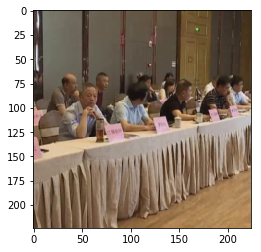

class      prob     score
0  无字幕内容  0.581616  8.682280
1  有字幕内容  0.301194  4.496187
2    演播室  0.117190  1.749399

-----------------------------


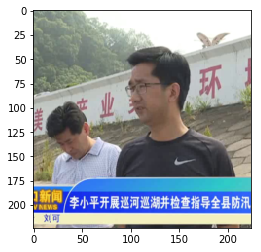

class      prob      score
1  有字幕内容  0.456642  12.268991
2    演播室  0.285899   7.681489
0  无字幕内容  0.257459   6.917387

-----------------------------


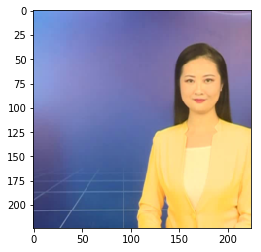

class      prob     score
2    演播室  0.650300  9.551328
0  无字幕内容  0.289873  4.257524
1  有字幕内容  0.059827  0.878714

-----------------------------


In [20]:
dir_path = '/home/Public/jxdaily-scenes-split/data/images/湖口/20190520.eval/'

files = [
    # 无字幕
    '湖口-20190520-66_3.jpg',
    # 有字幕
    '湖口-20190520-23_3.jpg',
    # '播音室'
    '湖口-20190520-19_1.jpg',
]

for fn in files:
    file_path = os.path.join(dir_path, fn)
    predict_image_by_url(file_path)
    print('-----------------------------')

### 预测随机数据

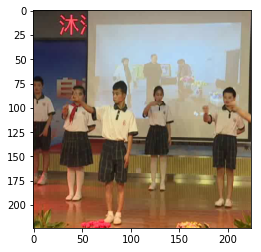

class      prob      score
0  无字幕内容  0.663310  11.444468
2    演播室  0.213589   3.685170
1  有字幕内容  0.123101   2.123925

-----------------------------


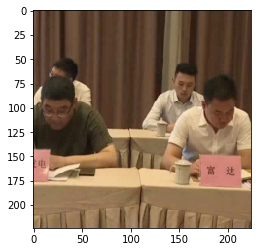

class      prob     score
0  无字幕内容  0.586300  9.833772
1  有字幕内容  0.293276  4.918997
2    演播室  0.120424  2.019816

-----------------------------


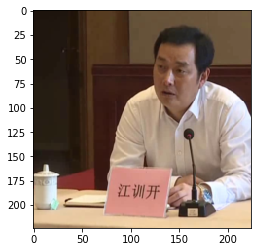

class      prob     score
0  无字幕内容  0.548243  9.687316
1  有字幕内容  0.237771  4.201353
2    演播室  0.213986  3.781080

-----------------------------


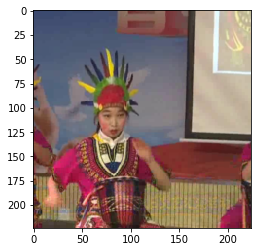

class      prob      score
0  无字幕内容  0.665709  12.752222
2    演播室  0.218599   4.187458
1  有字幕内容  0.115692   2.216182

-----------------------------


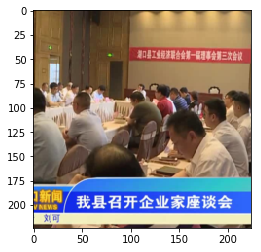

class      prob      score
1  有字幕内容  0.481852  14.169560
2    演播室  0.287226   8.446305
0  无字幕内容  0.230921   6.790572

-----------------------------


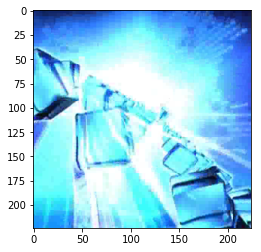

class      prob     score
0  无字幕内容  0.494254  7.962760
2    演播室  0.337451  5.436548
1  有字幕内容  0.168295  2.711341

-----------------------------


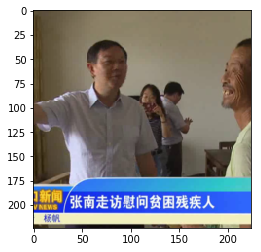

class      prob      score
1  有字幕内容  0.438471  10.765867
2    演播室  0.316348   7.767359
0  无字幕内容  0.245180   6.019950

-----------------------------


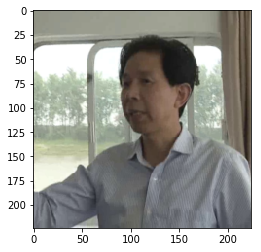

class      prob     score
0  无字幕内容  0.595924  9.494001
1  有字幕内容  0.213542  3.402058
2    演播室  0.190534  3.035497

-----------------------------


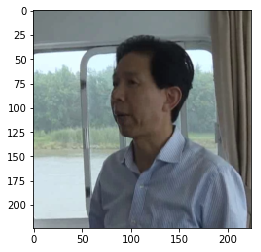

class      prob     score
0  无字幕内容  0.622151  9.737333
1  有字幕内容  0.191830  3.002351
2    演播室  0.186019  2.911399

-----------------------------


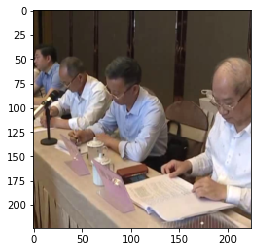

class      prob      score
0  无字幕内容  0.644534  11.062137
1  有字幕内容  0.244119   4.189809
2    演播室  0.111348   1.911066

-----------------------------
0:00:04.721212


In [21]:
image_files = glob('/home/Public/jxdaily-scenes-split/data/images/湖口/20190520.eval/*.jpg')
files = random.choices(image_files, k=10)

ts = time.time()

for fn in files:
    predict_image_by_url(fn)
    print('-----------------------------')

print(timedelta(seconds=time.time()-ts))

### 预测域外数据

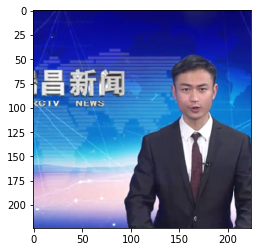

class      prob     score
0  无字幕内容  0.443625  7.113219
2    演播室  0.324713  5.206545
1  有字幕内容  0.231661  3.714524

In [22]:
# 用湖口的模型硬上，预测瑞昌的抓图:

predict_image_by_url('/home/Public/jxdaily-scenes-split/data/vlcsnap-2019-05-22-18h17m05s583.png')

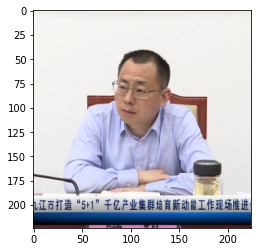

class      prob     score
1  有字幕内容  0.400565  8.419619
0  无字幕内容  0.366655  7.706866
2    演播室  0.232780  4.892887

In [23]:
# 用湖口的模型硬上，预测瑞昌的抓图:

predict_image_by_url('/home/Public/jxdaily-scenes-split/data/vlcsnap-2019-05-24-16h08m29s390.png')

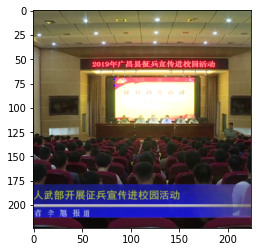

class      prob      score
0  无字幕内容  0.416531  10.385448
1  有字幕内容  0.355230   8.857022
2    演播室  0.228240   5.690745

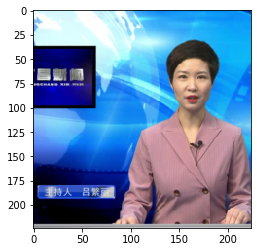

class      prob     score
0  无字幕内容  0.363142  7.555309
1  有字幕内容  0.342949  7.135180
2    演播室  0.293909  6.114875

In [24]:
# 用湖口的模型硬上，预测广昌的抓图:

predict_image_by_url('/home/Public/jxdaily-scenes-split/data/vlcsnap-2019-05-24-16h13m58s190.png')
predict_image_by_url('/home/Public/jxdaily-scenes-split/data/vlcsnap-2019-05-24-16h15m36s078.png')